In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [226]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv').dropna(axis=1, how='all')
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_filt = pd.read_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_grouping.csv', index_col=0)

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1060, 1092, 1062, 1093, 1101, 1102, 1074, 1076, 1082]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

## Katie raised questions about the trendline of the boxplots in analytical order. Is there an upward trend? Also, what is going on with QC1 being so low? 

### fit a regression line to random features to observe trends 

### the general trend is an upward slope

In [224]:
fr_raw

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,1.145548e+07,...,1.771940e+07,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.677270e+07,...,3.852845e+07,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.625939e+07,...,1.569916e+07,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.290199e+08,...,2.882770e+08,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,1.089197e+07,...,6.578465e+06,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.801313e+06,...,2.390561e+05,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,1.053780e+06,...,7.948007e+04,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.844701e+05,...,3.421911e+05,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830
1485,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,13749.188890,14296.409340,1.669550e+04,...,2.521927e+05,2.039074e+04,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230


60
slope:  [0.00828225]
y-intercept:  [22.29757175]


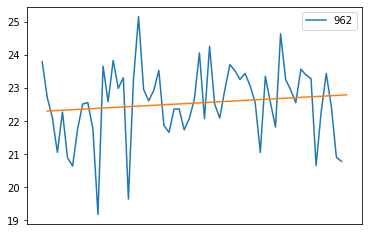

In [7]:
feat = np.log2(fr_raw.sort_values('Area (max)', ascending=False)[fr_quant_filenames_in_analytical_order]
        .filter(regex='RBG|FBG').sample().T)
feat.plot(xticks=[])

print(feat.shape[0])

# print(feat)

# get linear regression of data
fit = np.polyfit(x=range(1,feat.shape[0]+1), y=feat, deg=1)
print('slope: ', fit[0])
print('y-intercept: ', fit[1])

x=np.arange(1, feat.shape[0] + 1, dtype='float64')

plt.plot(x, (fit[0] * x + fit[1]))

plt.show()

### Histogram of slopes of regression lines for individual features is a normal distribution that trends upward. 

Therefore the data will generally trend upward in analytical order. 

array([[   630.59930867],
       [-91634.57298099],
       [ 86371.91623131],
       ...,
       [ -2206.66351669],
       [  3948.81030441],
       [  3080.72720451]])

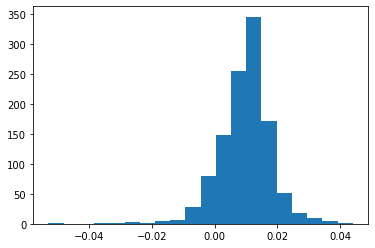

In [8]:
## Calculate all linear regression fits for all features and show histogram of slopes

fit_slopes = []

for index, row in fr_filt[fr_quant_filenames_in_analytical_order].iterrows():
    fit = LinearRegression().fit(np.arange(0,60).reshape(-1, 1),
                                              np.log2(row.T))
    fit_slopes.append(fit.coef_[0])

# print(fit_slopes)
# fit_slopes = np.array(fit_slopes).clip(-1000, 1000)
plt.hist(fit_slopes, bins=20)


from sklearn import linear_model

model = LinearRegression().fit(np.arange(0,60).reshape(-1, 1), 
                                            fr_filt[fr_quant_filenames_in_analytical_order].T)

model.coef_

# plt.plot(np.array(range(0,20)), np.arange(30, 50))

0.00035586527558313256
0.009174943179161165
21.156830311382222
[0.00917494]
0.19885098052896644


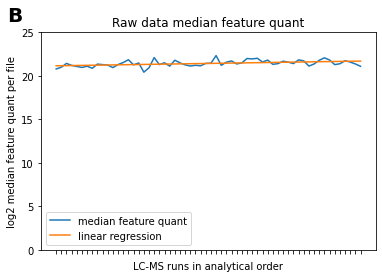

In [91]:
# plots of the medians of each file's quant
file_medians = fr_filt[fr_quant_filenames_in_analytical_order].median(axis=0)

model = LinearRegression().fit(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                                            np.log2(file_medians))

# Using scipy stats module to get p_value easily 
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                               np.log2(file_medians))
print(p_value)
print(slope)
print(intercept)

print(model.coef_)
print(model.score(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                  np.log2(file_medians)))

fig, ax = plt.subplots()

medians, = ax.plot(np.log2(file_medians))
medians.set_label('median feature quant')
 
fit_line, = ax.plot(np.arange(0,60), (np.arange(0,60) * model.coef_ + model.intercept_))
fit_line.set_label('linear regression')

ax.legend(handles=[medians, fit_line],)

ax.text(-0.1, 1.05, "B", transform=ax.transAxes, fontsize=20, weight='bold')


plt.ylabel('log2 median feature quant per file')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant')

plt.ylim((0, 25))

plt.xticks(list(range(0,60)), ['']*60);

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant raw zoomed out.png')

0.00035586527558313256
0.009174943179161165
21.156830311382222
[0.00917494]
0.19885098052896644


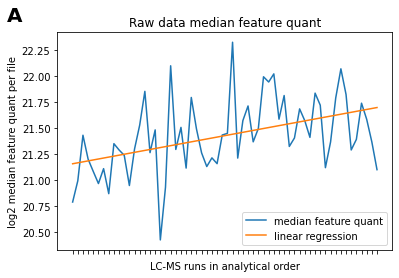

In [92]:
# plots of the medians of each file's quant
file_medians = fr_filt[fr_quant_filenames_in_analytical_order].median(axis=0)

model = LinearRegression().fit(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                                            np.log2(file_medians))

# Using scipy stats module to get p_value easily 
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                               np.log2(file_medians))
print(p_value)
print(slope)
print(intercept)

print(model.coef_)
print(model.score(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                  np.log2(file_medians)))

fig, ax = plt.subplots()

medians, = ax.plot(np.log2(file_medians))
medians.set_label('median feature quant')
 
fit_line, = ax.plot(np.arange(0,60), (np.arange(0,60) * model.coef_ + model.intercept_))
fit_line.set_label('linear regression')

ax.legend(handles=[medians, fit_line],)

ax.text(-0.15, 1.05, "A", transform=ax.transAxes, fontsize=20, weight='bold')

plt.ylabel('log2 median feature quant per file')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant')

# plt.ylim((0, 25))

plt.xticks(list(range(0,60)), ['']*60);

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant raw.png')

0.9883608378838142
3.497915452198543e-05
21.155793881590878
[3.49791545e-05]
3.7009145071875693e-06


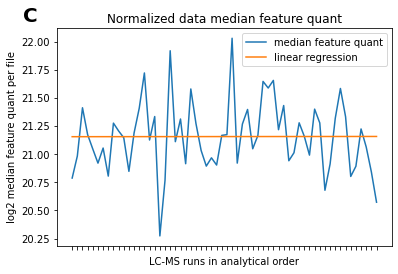

In [90]:
# plots of the medians of each file's quant
df = fr_norm

file_medians = df[fr_quant_filenames_in_analytical_order].median(axis=0)

model = LinearRegression().fit(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                                            np.log2(file_medians))

# Using scipy stats module to get p_value easily 
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                               np.log2(file_medians))
print(p_value)
print(slope)
print(intercept)

print(model.coef_)
print(model.score(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                  np.log2(file_medians)))

fig, ax = plt.subplots()

medians, = ax.plot(np.log2(file_medians))
medians.set_label('median feature quant')
 
fit_line, = ax.plot(np.arange(0,60), (np.arange(0,60) * model.coef_ + model.intercept_))
fit_line.set_label('linear regression')

ax.legend(handles=[medians, fit_line],)

ax.text(-0.1, 1.03, "C", transform=ax.transAxes, fontsize=20, weight='bold')


plt.ylabel('log2 median feature quant per file')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Normalized data median feature quant')

# plt.ylim((0, 25))

plt.xticks(list(range(0,60)), ['']*60);

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant normalized.png')

### Because the trend line slopes upward we can perform a normalization based on the slope

In [10]:
normalization_factor_arr = np.arange(0, 60)*slope + intercept 
normalization_factor_arr = (normalization_factor_arr[0] / normalization_factor_arr)
print(normalization_factor_arr)

[1.         0.99956652 0.99913342 0.9987007  0.99826835 0.99783637
 0.99740477 0.99697354 0.99654269 0.9961122  0.99568209 0.99525235
 0.99482298 0.99439398 0.99396535 0.99353709 0.9931092  0.99268167
 0.99225452 0.99182773 0.99140131 0.99097526 0.99054957 0.99012424
 0.98969929 0.98927469 0.98885047 0.9884266  0.9880031  0.98757996
 0.98715718 0.98673477 0.98631271 0.98589102 0.98546969 0.98504871
 0.9846281  0.98420785 0.98378795 0.98336841 0.98294924 0.98253041
 0.98211195 0.98169384 0.98127608 0.98085869 0.98044164 0.98002495
 0.97960862 0.97919264 0.97877701 0.97836174 0.97794681 0.97753224
 0.97711802 0.97670415 0.97629063 0.97587747 0.97546465 0.97505218]


[1.         0.99956652 0.99913342 0.9987007  0.99826835 0.99783637
 0.99740477 0.99697354 0.99654269 0.9961122  0.99568209 0.99525235
 0.99482298 0.99439398 0.99396535 0.99353709 0.9931092  0.99268167
 0.99225452 0.99182773 0.99140131 0.99097526 0.99054957 0.99012424
 0.98969929 0.98927469 0.98885047 0.9884266  0.9880031  0.98757996
 0.98715718 0.98673477 0.98631271 0.98589102 0.98546969 0.98504871
 0.9846281  0.98420785 0.98378795 0.98336841 0.98294924 0.98253041
 0.98211195 0.98169384 0.98127608 0.98085869 0.98044164 0.98002495
 0.97960862 0.97919264 0.97877701 0.97836174 0.97794681 0.97753224
 0.97711802 0.97670415 0.97629063 0.97587747 0.97546465 0.97505218]
new slope after normalization:  3.496506401874729e-05  --> is very close to 0


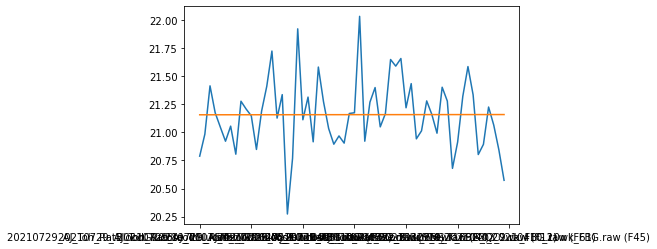

In [11]:
# Multiply each column by a factor that depends on the column index:
# Col 1 is multiplied by 1
# Col 2 multiplied by 0.99
# Col 3 by 0.98 ... 
# Using the slope and intercept from stats.linregress above:

normalization_factor_arr = np.arange(0, 60)*slope + intercept 
normalization_factor_arr = (normalization_factor_arr[0] / normalization_factor_arr)
print(normalization_factor_arr)


fr_norm = np.log2(fr_filt[fr_quant_filenames_in_analytical_order]) * normalization_factor_arr

fr_norm.median(axis=0).plot()

_slope, _intercept, _r_value, _p_value, _std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                                    fr_norm.median(axis=0))

plt.plot(np.arange(0,60), (np.arange(0,60)*_slope + _intercept))

print("new slope after normalization: ", _slope, " --> is very close to 0")

plt.ylabel('log2 median feature quant')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant over time')

plt.xticks(list(range(0,60)), ['']*60);

In [12]:
fr_norm = pd.concat([fr_filt.drop(fr_quant_filenames_in_analytical_order, axis=1), (2**fr_norm)], axis=1, ).reindex(fr_filt.columns, axis=1)
fr_norm

,Unique Identifier,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210410_10wk_FBG.raw (F57),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
0,unknown_679.05463_0.536,0.536,679.05463,+,2.408421e+07,unknown,unknown,49,9.961276e+06,1.691781e+07,...,1.156171e+07,9.016913e+06,5.355228e+06,1.613667e+07,1.206792e+07,1.076659e+07,1.182398e+07,9.694285e+06,9.361182e+06,1.109741e+07
1,unknown_641.1087_0.537,0.537,641.10870,+,5.522238e+07,unknown,unknown,36,4.018283e+07,5.395799e+07,...,3.205050e+07,2.397982e+07,2.031440e+07,3.493457e+07,3.004373e+07,4.955608e+06,3.171840e+07,2.794023e+07,2.183496e+07,2.334052e+07
2,unknown_951.15973_0.541,0.541,951.15973,-,3.238113e+07,unknown,unknown,10,1.409607e+07,3.166167e+07,...,1.689302e+07,1.181936e+07,1.123874e+07,1.430660e+07,1.397276e+07,9.600099e+06,1.528755e+07,1.456458e+07,1.339975e+07,1.256650e+07
3,unknown_329.03067_0.542,0.542,329.03067,-,2.882770e+08,unknown,unknown,55,1.098792e+08,6.603763e+07,...,1.464271e+08,1.469389e+08,1.041182e+08,2.584545e+08,8.073146e+07,1.105607e+08,1.275793e+08,1.598260e+08,1.168454e+08,1.305405e+08
4,unknown_969.13147_0.544,0.544,969.13147,-,1.697296e+07,unknown,unknown,14,9.475374e+06,1.660978e+07,...,6.825044e+06,7.114039e+06,5.190140e+06,6.024237e+06,5.958120e+06,3.484823e+06,8.584741e+06,7.847293e+06,5.852656e+06,7.425286e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,unknown_974.9118_20.163,20.163,974.91180,+,4.515337e+06,unknown,unknown,4,5.869303e+05,3.532438e+05,...,3.281323e+05,4.244548e+05,1.012860e+05,3.625526e+05,3.020530e+05,4.624497e+05,2.456722e+05,8.708906e+05,4.061090e+05,5.940236e+05
1482,unknown_593.58716_20.175,20.175,593.58716,+,3.296976e+06,unknown,unknown,19,1.591473e+06,1.838194e+05,...,7.546669e+05,2.927913e+05,3.470343e+05,2.230221e+05,9.924767e+05,2.404754e+05,6.770359e+05,5.013473e+05,1.194394e+06,1.793828e+05
1483,unknown_871.80945_20.196,20.196,871.80945,+,2.595829e+06,unknown,unknown,6,9.353241e+05,7.538307e+04,...,4.703338e+05,1.134936e+05,2.430057e+05,7.460833e+04,6.600295e+05,7.516016e+04,3.906703e+05,1.004837e+05,7.709440e+05,3.733296e+04
1484,unknown_1003.93829_20.435,20.435,1003.93829,+,3.203813e+06,unknown,unknown,4,5.214056e+05,2.594792e+05,...,2.187251e+05,4.853630e+05,3.783643e+04,3.185984e+05,3.057656e+05,6.495841e+05,1.552571e+05,8.990945e+05,3.311393e+05,4.674901e+05


In [13]:
fr_norm.to_csv(r'..\data\processed\run_1_median_linregress_normalized_data.csv')

In [14]:
fr_norm = pd.read_csv(r'..\data\processed\run_1_median_linregress_normalized_data.csv', index_col=0)
file_grouping = pd.read_csv(r'..\data\metadata\file_groupings.csv', 
                            index_col=0,
                            dtype={'week': 'Int64', 'rat_label': 'Int64'})
fr_norm

,Unique Identifier,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210410_10wk_FBG.raw (F57),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
0,unknown_679.05463_0.536,0.536,679.05463,+,2.408421e+07,unknown,unknown,49,9.961276e+06,1.691781e+07,...,1.156171e+07,9.016913e+06,5.355228e+06,1.613667e+07,1.206792e+07,1.076659e+07,1.182398e+07,9.694285e+06,9.361182e+06,1.109741e+07
1,unknown_641.1087_0.537,0.537,641.10870,+,5.522238e+07,unknown,unknown,36,4.018283e+07,5.395799e+07,...,3.205050e+07,2.397982e+07,2.031440e+07,3.493457e+07,3.004373e+07,4.955608e+06,3.171840e+07,2.794023e+07,2.183496e+07,2.334052e+07
2,unknown_951.15973_0.541,0.541,951.15973,-,3.238113e+07,unknown,unknown,10,1.409607e+07,3.166167e+07,...,1.689302e+07,1.181936e+07,1.123874e+07,1.430660e+07,1.397276e+07,9.600099e+06,1.528755e+07,1.456458e+07,1.339975e+07,1.256650e+07
3,unknown_329.03067_0.542,0.542,329.03067,-,2.882770e+08,unknown,unknown,55,1.098792e+08,6.603763e+07,...,1.464271e+08,1.469389e+08,1.041182e+08,2.584545e+08,8.073146e+07,1.105607e+08,1.275793e+08,1.598260e+08,1.168454e+08,1.305405e+08
4,unknown_969.13147_0.544,0.544,969.13147,-,1.697296e+07,unknown,unknown,14,9.475374e+06,1.660978e+07,...,6.825044e+06,7.114039e+06,5.190140e+06,6.024237e+06,5.958120e+06,3.484823e+06,8.584741e+06,7.847293e+06,5.852656e+06,7.425286e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,unknown_974.9118_20.163,20.163,974.91180,+,4.515337e+06,unknown,unknown,4,5.869303e+05,3.532438e+05,...,3.281323e+05,4.244548e+05,1.012860e+05,3.625526e+05,3.020530e+05,4.624497e+05,2.456722e+05,8.708906e+05,4.061090e+05,5.940236e+05
1482,unknown_593.58716_20.175,20.175,593.58716,+,3.296976e+06,unknown,unknown,19,1.591473e+06,1.838194e+05,...,7.546669e+05,2.927913e+05,3.470343e+05,2.230221e+05,9.924767e+05,2.404754e+05,6.770359e+05,5.013473e+05,1.194394e+06,1.793828e+05
1483,unknown_871.80945_20.196,20.196,871.80945,+,2.595829e+06,unknown,unknown,6,9.353241e+05,7.538307e+04,...,4.703338e+05,1.134936e+05,2.430057e+05,7.460833e+04,6.600295e+05,7.516016e+04,3.906703e+05,1.004837e+05,7.709440e+05,3.733296e+04
1484,unknown_1003.93829_20.435,20.435,1003.93829,+,3.203813e+06,unknown,unknown,4,5.214056e+05,2.594792e+05,...,2.187251e+05,4.853630e+05,3.783643e+04,3.185984e+05,3.057656e+05,6.495841e+05,1.552571e+05,8.990945e+05,3.311393e+05,4.674901e+05


### Create PCAs of normalized data

In [16]:
pca_data = fr_norm[fr_quant_filenames_in_analytical_order].T

# pd.merge (and df.merge()) is how you do database join 
pca_data = pd.merge(pca_data, file_grouping[['fr_name', 'rat_label', 'bg_type']],
                    how='inner', left_on=pca_data.index, right_on='fr_name',)\
                    .set_index(pca_data.index).drop('fr_name', axis=1)
pca_data

,0,1,2,3,4,5,6,7,8,9,...,1473,1479,1480,1481,1482,1483,1484,1486,rat_label,bg_type
20210729_AJ_Toh_RatBloodGlucose_T1076M_20210405_10wk_FBG.raw (F27),1.388749e+06,3.035806e+06,1.663567e+06,2.215194e+07,6.816564e+05,8.682616e+06,3.747518e+08,1.902448e+05,6.530761e+05,2.106110e+07,...,3.574035e+05,8.765036e+04,4.881645e+05,1.149073e+05,2.165170e+05,3.460561e+05,1.032091e+05,1.395636e+04,1076,FBG
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw (F9),1.042115e+07,2.518605e+07,1.392469e+07,1.177824e+08,6.859021e+06,8.005044e+07,1.326488e+09,2.917500e+05,4.217597e+06,7.913322e+07,...,7.455113e+05,1.941844e+05,6.674987e+05,1.687196e+05,6.192762e+05,3.932969e+05,8.144660e+04,8.358880e+04,1062,FBG
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210402_9wk_FBG.raw (F49),9.760335e+06,2.175648e+07,8.615691e+06,1.096654e+08,3.459855e+06,7.118307e+07,8.111771e+08,8.962073e+05,4.653153e+06,5.186759e+07,...,2.781841e+06,2.266050e+06,3.026776e+06,1.123399e+06,2.826003e+06,2.051036e+06,6.631899e+05,4.695486e+05,1093,FBG
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),1.691781e+07,5.395799e+07,3.166167e+07,6.603763e+07,1.660978e+07,1.644834e+08,4.114053e+09,4.161237e+05,4.975742e+06,1.347057e+08,...,1.577400e+06,3.531664e+05,2.481525e+05,3.532438e+05,1.838194e+05,7.538307e+04,2.594792e+05,1.904778e+05,1060,RBG
20210729_AJ_Toh_RatBloodGlucose_T1091M_20210410_10wk_FBG.raw (F39),2.068295e+07,4.495125e+07,1.727584e+07,1.667585e+08,5.238700e+06,1.263464e+08,1.471754e+09,1.156155e+06,5.831464e+06,8.632717e+07,...,9.780301e+05,3.153424e+05,1.149945e+06,2.596903e+05,1.045870e+06,8.989649e+05,1.679354e+05,1.515954e+05,1091,FBG
20210729_AJ_Toh_RatBloodGlucose_T1092M_20210406_9wk_RBG.raw (F44),1.566393e+07,3.210691e+07,1.877686e+07,1.694723e+08,9.532403e+06,1.076569e+08,1.731782e+09,2.874464e+05,5.910521e+06,8.406144e+07,...,1.025856e+06,3.506216e+05,2.320367e+05,2.808097e+05,1.709037e+05,4.817732e+04,1.962425e+05,1.505868e+05,1092,RBG
20210729_AJ_Toh_RatBloodGlucose_T1093M_20210413_10wk_RBG.raw (F52),1.546696e+07,2.879476e+07,1.295828e+07,1.789388e+08,7.275446e+06,7.900832e+07,9.702365e+08,6.507078e+05,5.296912e+06,5.831564e+07,...,1.115585e+06,3.278851e+05,4.680471e+05,2.898609e+05,3.187819e+05,9.957186e+04,2.424102e+05,1.834479e+05,1093,RBG
20210729_AJ_Toh_RatBloodGlucose_T1082M_20210405_10wk_FBG.raw (F33),1.097162e+07,2.717046e+07,1.779705e+07,1.573730e+08,7.708929e+06,8.299244e+07,1.155493e+09,2.609918e+05,6.411470e+06,6.807377e+07,...,4.700943e+05,4.216820e+04,6.255376e+05,2.311439e+04,7.451995e+05,6.815743e+05,1.473037e+04,2.196649e+04,1082,FBG
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw (F6),2.246001e+07,3.483616e+07,9.429265e+06,2.031222e+08,5.522723e+06,7.306498e+07,8.820650e+08,3.041119e+05,7.248599e+06,4.943534e+07,...,1.568714e+06,5.056816e+05,3.141871e+05,4.738119e+05,2.155482e+05,9.229856e+04,3.621453e+05,2.126421e+05,1060,RBG
20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),1.156171e+07,3.205050e+07,1.689302e+07,1.464271e+08,6.825044e+06,1.074644e+08,1.333837e+09,4.893998e+06,6.037140e+06,7.845387e+07,...,1.176574e+06,6.391238e+05,8.425491e+05,3.281323e+05,7.546669e+05,4.703338e+05,2.187251e+05,1.534330e+04,1101,FBG


In [149]:
n_components = 2
pca = PCA(n_components=n_components)

scaled = StandardScaler().fit_transform(pca_data.drop(['bg_type', 'rat_label'], axis=1))
fitted = pca.fit_transform(scaled)
columns = ['pc' + str(x) for x in range(1, n_components+1)]
fitted = pd.DataFrame(fitted, columns=columns)

pca_data = pd.concat([fitted, pca_data.reset_index()[['bg_type', 'rat_label']]], axis=1)
pca_data

,pc1,pc2,bg_type,rat_label
0,-22.245035,10.828642,FBG,1076
1,-23.202568,14.708948,FBG,1062
2,-14.128190,12.787347,FBG,1093
3,4.349870,-12.135575,RBG,1060
4,-18.441753,3.227266,FBG,1091
5,9.081670,-23.430535,RBG,1092
6,3.656178,-17.251562,RBG,1093
7,-17.862053,-3.614451,FBG,1082
8,18.788769,-16.964551,RBG,1060
9,-10.408957,3.161798,FBG,1101


In [150]:
pca_data['rat_label'].values[0]

1076

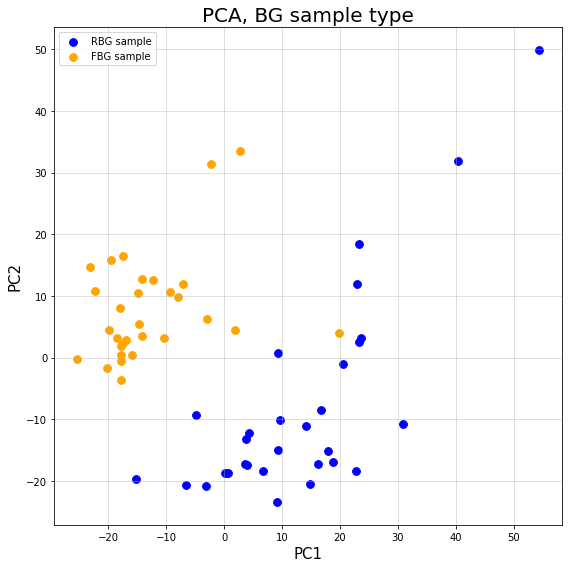

In [151]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, BG sample type', fontsize = 20)
targets = ['RBG', 'FBG']
target_colors = ['blue', 'orange']
markers = ['o', 's']
rat_labels = ['1101', '1092', '1062', '1082', '1102', '1091', '1076', '1060', '1074', '1093']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

for target, color in zip(targets, target_colors):
#     for label, color in zip(rat_labels, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target)] 
#         print(scatter_points)
        ax.scatter(scatter_points['pc1'],
                   scatter_points['pc2'],
                   c = color,
                   cmap='viridis',
#                    marker=marker,
                   s = 60)
ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()


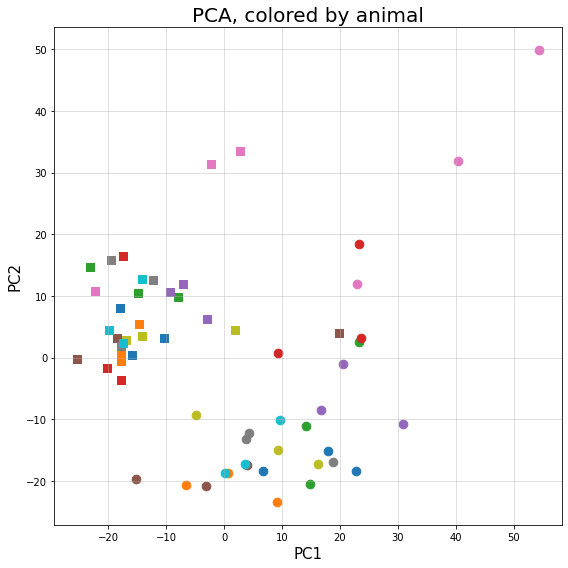

In [152]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA, colored by animal', fontsize = 20)
targets = ['RBG', 'FBG']
markers = ['o', 's']
rat_labels = ['1101', '1092', '1062', '1082', '1102', '1091', '1076', '1060', '1074', '1093']
rat_labels = [int(x) for x in rat_labels]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# colors = [plt.get_cmap('Dark2')(i) for i in range(1, 11)]

for target, marker in zip(targets,markers):
    for label, color in zip(rat_labels, colors):
        scatter_points = pca_data[(pca_data['bg_type'] == target) & (pca_data['rat_label'] == label)]
#         print(scatter_points)
        ax.scatter(scatter_points['pc1'],
                   scatter_points['pc2'],
                   c = color,
#                    cmap='viridis',
                   marker=marker,
                   s = 75,
                   )
        
# ax.legend(['RBG sample', 'FBG sample'],)
ax.grid(alpha=0.5)
plt.tight_layout()

### The Boxiest of Boxplots using regression normalized data



60


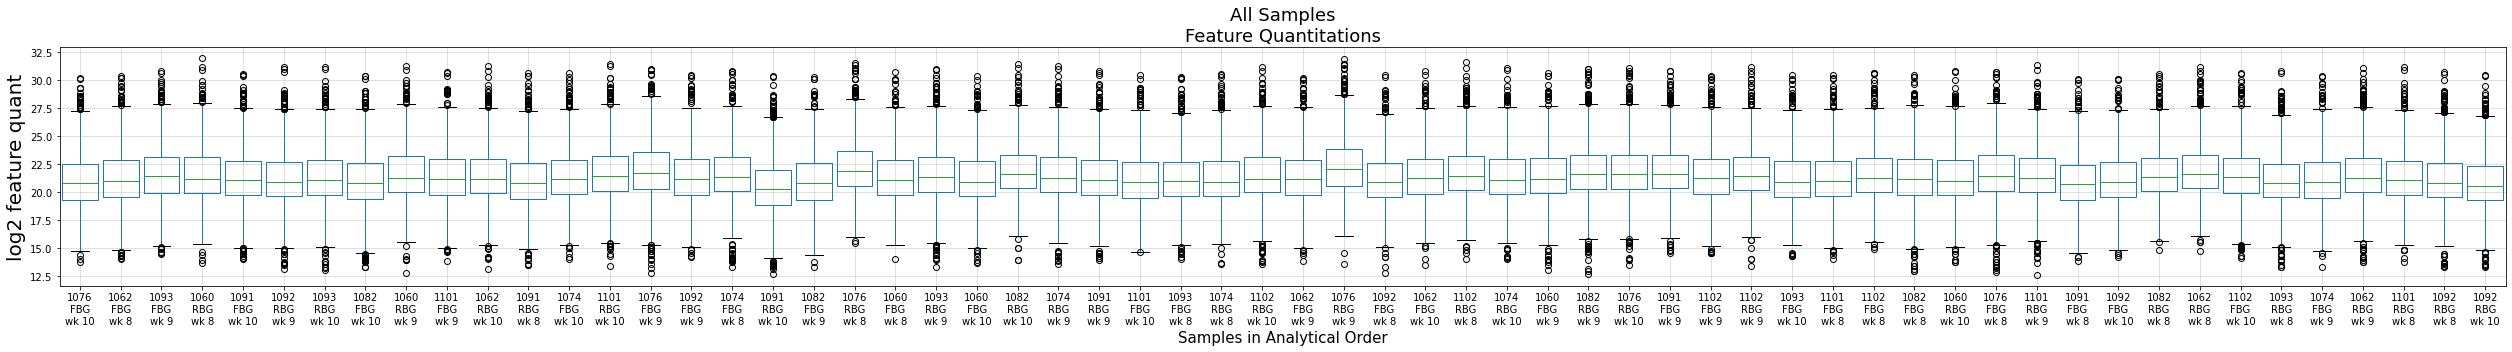

In [153]:
fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

np.log2(fr_norm[fr_quant_filenames_in_analytical_order]).boxplot(widths=0.88)


fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((35, 5))
ax.grid(True, alpha=0.5)

# Get the LipiDex file number (F43) for each file
# labels = [re.search(r'\((.*?)\)', col_name).group(1) for col_name in fr_quant_filenames_in_analytical_order]

labels = []

for filename in fr_quant_filenames_in_analytical_order:
    rat_label = str(int(file_grouping[file_grouping['fr_name'] == filename]['rat_label'].values[0]))
    bg_type = file_grouping[file_grouping['fr_name'] == filename]['bg_type'].values[0]
    week = str(int(file_grouping[file_grouping['fr_name'] == filename]['week'].values[0]))
    labels.append(f'{rat_label}\n{bg_type}\nwk {week}')

print(len(set(labels)))
    
plt.xticks(range(1, 61), labels=labels)
# plt.xticks(range(1, 61), labels=samples.columns.to_list(), fontsize=15, rotation=90)
plt.xlabel('Samples in Analytical Order', fontsize=15)
plt.ylabel('log2 feature quant', fontsize=20)
plt.title('All Samples\nFeature Quantitations', fontsize=18)
plt.tight_layout()

In [159]:
# qc1_median = np.log2(fr_norm.filter(regex='QC1')).median()
all_median = np.log2(fr_norm.filter(regex='.raw').mean(axis=1)).median()
qc2_qc3_median = np.log2(fr_norm.filter(regex='QC2|QC3').mean(axis=1)).median()
fr_norm.filter(regex='QC2|QC3')

,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC2.raw (F12)
0,8.620075e+06
1,2.228472e+07
2,1.045787e+07
3,1.103581e+08
4,6.701929e+06
...,...
1481,2.644414e+05
1482,6.998475e+05
1483,4.164114e+05
1484,7.508810e+04


30


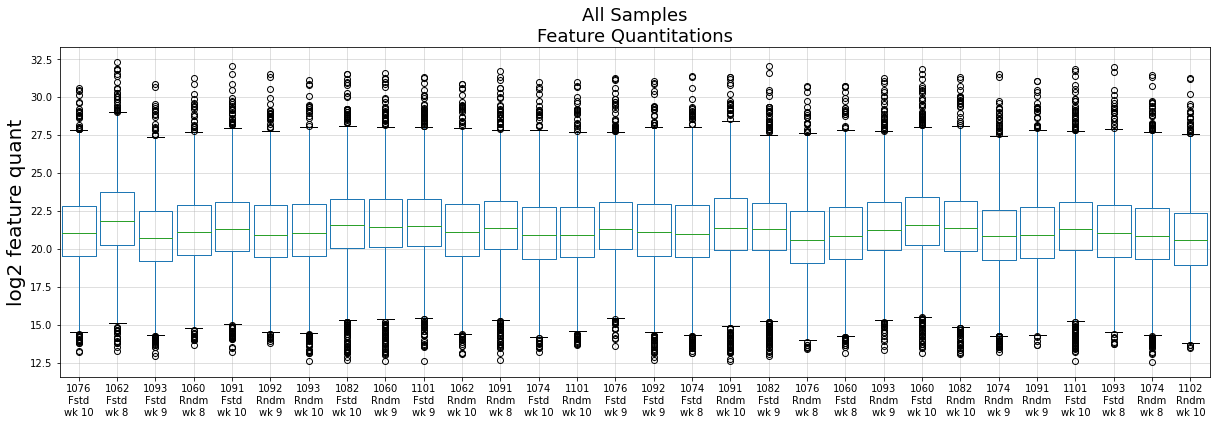

In [235]:
np.log2(fr_raw[fr_quant_filenames_in_analytical_order].iloc[:,30:]).boxplot(widths=0.88)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((17, 6))
ax.grid(True, alpha=0.5)

# Get the LipiDex file number (F43) for each file
# labels = [re.search(r'\((.*?)\)', col_name).group(1) for col_name in fr_quant_filenames_in_analytical_order]

labels = []

for filename in fr_quant_filenames_in_analytical_order[0:30]:
    rat_label = str(int(file_grouping[file_grouping['fr_name'] == filename]['rat_label'].values[0]))
    bg_type = file_grouping[file_grouping['fr_name'] == filename]['bg_type'].values[0]
    week = str(int(file_grouping[file_grouping['fr_name'] == filename]['week'].values[0]))
    labels.append(f'{rat_label}\n' + ('Rndm' if bg_type == 'RBG' else 'Fstd') + f'\nwk {week}')

print(len(set(labels)))

# plt.plot([0.5, 30.5], [qc1_median, qc1_median], c='r')
# plt.plot([0.5, 30.5], [all_median, all_median], c='orange', linewidth=3)
# plt.plot([0.5, 30.5], [qc2_qc3_median, qc2_qc3_median], c='purple', linewidth=3)
    
plt.xticks(range(1, 31), labels=labels)
# plt.xticks(range(1, 61), labels=samples.columns.to_list(), fontsize=15, rotation=90)
# plt.xlabel('Samples in Analytical Order', fontsize=15)
plt.ylabel('log2 feature quant', fontsize=20)
plt.title('All Samples\nFeature Quantitations', fontsize=18)
plt.tight_layout()

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\all samples feature quant analytical order 1.png')           


30


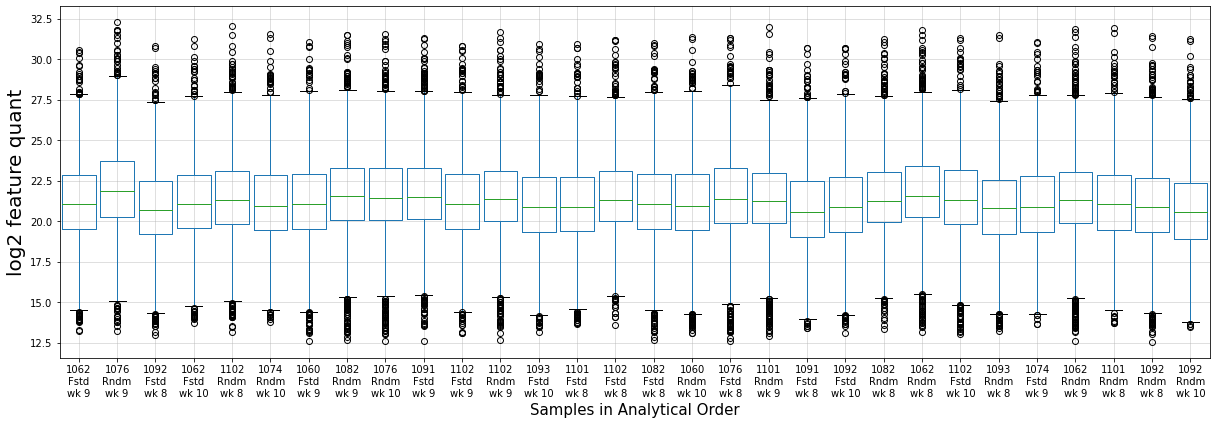

In [236]:
np.log2(fr_raw[fr_quant_filenames_in_analytical_order].iloc[:,30:]).boxplot(widths=0.88)

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches((17, 6))
ax.grid(True, alpha=0.5)

# Get the LipiDex file number (F43) for each file
# labels = [re.search(r'\((.*?)\)', col_name).group(1) for col_name in fr_quant_filenames_in_analytical_order]

labels = []

for filename in fr_quant_filenames_in_analytical_order[30:]:
    rat_label = str(int(file_grouping[file_grouping['fr_name'] == filename]['rat_label'].values[0]))
    bg_type = file_grouping[file_grouping['fr_name'] == filename]['bg_type'].values[0]
    week = str(int(file_grouping[file_grouping['fr_name'] == filename]['week'].values[0]))
    labels.append(f'{rat_label}\n' + ('Rndm' if bg_type == 'RBG' else 'Fstd') + f'\nwk {week}')

print(len(set(labels)))

# plt.plot([0.5, 30.5], [qc1_median, qc1_median], c='r')
# plt.plot([0.5, 30.5], [all_median, all_median], c='orange', linewidth=3)
# plt.plot([0.5, 30.5], [qc2_qc3_median, qc2_qc3_median], c='purple', linewidth=3)
    
plt.xticks(range(1, 31), labels=labels)
# plt.xticks(range(1, 61), labels=samples.columns.to_list(), fontsize=15, rotation=90)
plt.xlabel('Samples in Analytical Order', fontsize=15)
plt.ylabel('log2 feature quant', fontsize=20)
# plt.title('All Samples\nFeature Quantitations', fontsize=18)
plt.tight_layout()

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\all samples feature quant analytical order 2.png')           


In [7]:
from sortedcollections import SortedList

data = SortedList([1900.0545 , 2008.5400 , 2455.5466 , 1845.5879])
test = list(data.irange(0.95 * 2009, 1.05 * 2009)) 
if test:
    print('There are values within the range and they are',test)
else:
    print('There are no values in the given range.')
    
    
    
theoretical_masses = [100.6, 200.1]
    
peaklist = [(100.0, 0.5), (200.0, 0.1)]

extracted_masses = [x[0] for x in peaklist]


sorted_masses = SortedList(extracted_masses)

for theoretical_mass in theoretical_masses:
    print(list(sorted_masses.irange(theoretical_mass-0.5, theoretical_mass+0.5)))
    
    
    
for mass in theoretical_masses:
    
    

There are values within the range and they are [2008.54]
[]
[200.0]


In [66]:
from timeit import timeit
from itertools import tee
from random import uniform

#check if two floats are close enough to match
def matching(mz1, mz2):
    if abs( (1-mz1/mz2) * 1000000) <= 2:
        return True
    return False

#imagine another huge for loop around everything
l1 = sorted([uniform(130.00, 135.00) for _ in range(1)])
l2 = sorted([uniform(130.00, 135.00) for _ in range(10000)])

def method1():
    d = {i:[] for i in l1}
    for i in l1:
        for j in l2:
            if matching(i, j):
                d[i].append(j)
    return d

def theoretical_mass_search(theo_mzs, exp_mzs, tol=0.5):
    # derived from https://stackoverflow.com/a/57362193  
    
    # theo_mzs: list of mz floats from fragments() function
    # exp_mzs: list of (mz, intensity) tuples from rawfile
    # tol: tolerance in Daltons for search 
    # returns: list of (mz, intensity) tuples within tolerance range that are maximum within that window
    
    
    theo_mzs = sorted(theo_mzs)  # algorithm requires both experiment and theoretical lists to be sorted
    
    exp_dict = {x[0]: x[1] for x in exp_mzs}  # convert to dictionary for easier lookup
    
    
    
    iter_2, last_match = tee(iter(exp_dict))
    d = {}
    for theo_mz in theo_mzs:
        d.setdefault(theo_mz, [])
        found = False
        while True:
            j = next(iter_2, None)
            if j is None:
                break
            if matching(theo_mz, j):
                d[theo_mz].append(j)
                if not found:
                    iter_2, last_match = tee(iter_2)
                    found = True
            else:
                if found:
                    break
        iter_2, last_match = tee(last_match)
    return d

# dict_ = theoretical_mass_search([100.1, 200.2], [(100.0, 0.5), (200.0, 0.1)])
dict_ = theoretical_mass_search([100.1, 200.2], [(100.0, 0.5), (200.0, 0.1)])
print(dict_)

# print(timeit(lambda: method1(), number=1))
print(timeit(lambda: method2(l1, l2), number=1))

{100.1: [], 200.2: []}
0.0006747000006726012


In [60]:
peaks = [(1,2,), (3,4,)]

{x[0]:x[1] for x in peaks}

{1: 2, 3: 4}

In [62]:
import sys
print(sys.version)

3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]


In [177]:
import numpy as np

li = np.array([[1, 2],
               [1, 3],
               [1.1, 4.1],
               [3, 4],
               [5, 6],
               [7, 8],
               [9,10],])

search_results = []

for theo in [1, 3, 4]:
    # mask in the sense of "boolean masking"
    mask = np.isclose(theo, li[:, 0], rtol=0, atol=0.5).T

    result = li[mask]

    if result.shape[0] > 1:  # if the first dimension > 1, then we have multiple masses in the range, so return highest
        row_index_of_max_val = np.argmax(np.max(result, axis=1))
        result = result[row_index_of_max_val]
    
    search_results.append(result)

print(search_results)
    
np.vstack(search_results)

[array([1.1, 4.1]), array([[3., 4.]]), array([], shape=(0, 2), dtype=float64)]


array([[1.1, 4.1],
       [3. , 4. ]])

In [203]:


def search_peaklist(peaklist, theo_mzs, tol=0.5):
    # peaklist: list of (mz, intensity) tuples
    # theo_mzs: list of theoretical mzs from fragments() function
    # tol: mass tolerance in Daltons
    # returns: list of (mz, intensity) tuples from rawfile that match theoretical mzs
    #         Only returns maximum intensity peak found for each theoretical mz
    
    peaklist = np.array(peaklist)
    
    search_results = []
    
    for theo_mz in theo_mzs:
        # mask in the sense of "boolean masking" --> Google "what is boolean masking numpy"
        mask = np.isclose(theo_mz, peaklist[:, 0], rtol=0, atol=tol).T  # transpose to get right shape
        result = peaklist[mask]
        if result.shape[0] > 1:  # if the first dimension > 1, then we have multiple masses in the range, so return highest
            row_index_of_max_val = np.argmax(np.max(result, axis=1))
            result = result[row_index_of_max_val]
        search_results.append(result)
        
    return list(map(tuple, np.vstack(search_results)))  # converts numpy Nx2 array back into list of tuples



# If you want this function to be intelligent about the search, and say 
# "if this peak was already selected for an ion, then don't select it again, do a comparison 

In [218]:
from collections import defaultdict
dot_prod_dict = {}
dot_prod_dict = defaultdict(lambda: {}, dot_prod_dict)

for sublist in long_list:
    # long_list is the list of lists with [['PEPTIDE', 123.456, 15, [(150.0, 0.9), (200.0, 0.5)] ], ...]
    
    peptide_seq = sublist[0]
    precursor_mz = sublist[1]
    ce = sublist[2]
    exp_peaklist = sublist[3]
    
    theoretical_mzs = fragments(peptide_seq)
    
    filtered_exp_peaklist = search_peaklist(peaklist=exp_peaklist,
                                            theo_mzs=theoretical_mzs)
    
    prosit_spectrum_parsed_from_msp =  prosit_msp_dict[peptide_seq][ce]  # Get the Prosit spectrum from our populated dictionary
    
    dot_product_score = pyteomics.cant_remember_cosine_score_function(filtered_exp_peaklist, prosit_spectrum_parsed_from_msp)
    
    # Write result into our dot_prod_dict
    dot_prod_dict[peptide_seq][ce] = dot_product_score


NameError: name 'long_list' is not defined

In [217]:
from collections import defaultdict

d = {}
d = defaultdict(lambda: {}, d)

d['peptide'][15] = 2

d['pep'][50] = [(1,2), (3,4)]
d['pep'][10] = [(1,2), (3,4)]

d['no']

d


defaultdict(<function __main__.<lambda>()>,
            {'peptide': {15: 2},
             'pep': {50: [(1, 2), (3, 4)], 10: [(1, 2), (3, 4)]},
             'no': {}})

In [204]:
print(search_peaklist(peaklist=[(1,2,),(1,3),(2,3),(3,4,), (2.1, 5), (1.5, 7)],
                    theo_mzs=[1,2,5, 3],
                    tol=0.5))

[(1.5, 7.0), (1.5, 7.0), (3.0, 4.0)]

In [166]:
list(map(tuple, np.array([(1,2), (3,4)])))

[(1, 2), (3, 4)]

In [170]:
np.array([[1,23, 4],[3,4, 6]]).shape

(2, 3)

In [115]:
concat_list = []

for theo in [2, 1, 3]:
    mask = np.isclose(theo, li[0], rtol=0, atol=0.5)
    data = np.array( [li[0][mask], li[1][mask]] )
#     print(data)
    
    concat_list.append(data)

print(concat_list)
    
np.hstack(concat_list)

[array([[ 2.],
       [30.]]), array([[ 1. ,  1.4,  1. ],
       [10. , 20. , 40. ]]), array([[3.],
       [0.]])]


array([[ 2. ,  1. ,  1.4,  1. ,  3. ],
       [30. , 10. , 20. , 40. ,  0. ]])

In [149]:
x = np.random.random((5,5))
print(x)
print(np.unravel_index(np.argmax(x), x.shape))

[[0.64359429 0.50287939 0.42756339 0.2469078  0.94255885]
 [0.30411377 0.59909128 0.74062747 0.34966799 0.71772887]
 [0.97038764 0.22495791 0.40435043 0.08403688 0.50244514]
 [0.52320933 0.43517744 0.67986689 0.13392469 0.37564201]
 [0.33162832 0.7598469  0.91053563 0.59854506 0.20146578]]
(2, 0)
